In [1]:
import os
import pathlib
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Define the directory of the dataset
data_dir = pathlib.Path('CatsDogs/')

# Remove corrupted files
os.system("rm CatsDogs/Cats/666.jpg CatsDogs/Dogs/11702.jpg CatsDogs/Dogs/11410.jpg")

# Collects the path of all the files within the dataset
data_paths = [str(path) for path in list(data_dir.glob("*/*.jpg"))]
print(f"Images in the dataset: {len(data_paths)}")

rm: cannot remove 'CatsDogs/Cats/666.jpg': No such file or directory
rm: cannot remove 'CatsDogs/Dogs/11702.jpg': No such file or directory
rm: cannot remove 'CatsDogs/Dogs/11410.jpg': No such file or directory


Images in the dataset: 24997


In [ ]:
# Convert non-jpeg images into jpeg files
formats = [(path, Image.open(path).format) for path in data_paths]
non_jpegs = list(filter(lambda x: x[1]!='JPEG', formats))
for path, _ in non_jpegs:
    img = Image.open(path)
    img.convert('RGB').save(path, format='JPEG')

In [4]:
# Create the respective tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
# Shuffle the dataset
dataset = dataset.shuffle(len(data_paths), reshuffle_each_iteration=False)

2022-07-23 14:37:08.949015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 14:37:09.073815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 14:37:09.074584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 14:37:09.077640: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
# Get the class names
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Cats' 'Dogs']


In [6]:
# Create a test set
test_size = int(len(list(dataset)) * 0.2)
train = dataset.skip(test_size)
test = dataset.take(test_size)

# Create a validation set
val_size = int(len(list(train)) * 0.2)
val = train.take(val_size)
train = train.skip(val_size)

In [7]:
# Set initial params for the loader
batch_size = 64
img_height = 256
img_width = 256

In [8]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [9]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [10]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# Create a dataset of image, label pairs
train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
# Configure dataset for performance
def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train = configure_for_performance(train)
val = configure_for_performance(val)
test = configure_for_performance(test)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(8, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [15]:
n_epochs = 15

history = model.fit(
    train,
    validation_data=val,
    epochs=n_epochs
)

Epoch 1/15


2022-07-23 14:37:15.485552: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-23 14:37:21.384583: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 28/250 [==>...........................] - ETA: 1:04 - loss: 0.8468 - accuracy: 0.5022

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 80/250 [========>.....................] - ETA: 49s - loss: 0.7469 - accuracy: 0.5021

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


103/250 [===========>..................] - ETA: 42s - loss: 0.7349 - accuracy: 0.5053

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


121/250 [=============>................] - ETA: 37s - loss: 0.7287 - accuracy: 0.5026

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 28s - loss: 0.7215 - accuracy: 0.5015

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


230/250 [==========================>...] - ETA: 5s - loss: 0.7118 - accuracy: 0.5044

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


250/250 [==============================] - ETA: 0s - loss: 0.7104 - accuracy: 0.5022

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 100s 351ms/step - loss: 0.7104 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 2/15
 29/250 [==>...........................] - ETA: 32s - loss: 0.6932 - accuracy: 0.4935

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 23s - loss: 0.6932 - accuracy: 0.4853

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 20s - loss: 0.6932 - accuracy: 0.4877

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 17s - loss: 0.6932 - accuracy: 0.4881

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4889

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4947

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4940

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 164ms/step - loss: 0.6932 - accuracy: 0.4940 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 3/15
 29/250 [==>...........................] - ETA: 29s - loss: 0.6932 - accuracy: 0.4855

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 23s - loss: 0.6932 - accuracy: 0.5002

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 20s - loss: 0.6932 - accuracy: 0.4989

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 17s - loss: 0.6932 - accuracy: 0.4963

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4957

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4990

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


250/250 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4982

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 165ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 4/15
 29/250 [==>...........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5065

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 22s - loss: 0.6932 - accuracy: 0.4963

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 19s - loss: 0.6932 - accuracy: 0.4943

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 17s - loss: 0.6932 - accuracy: 0.4949

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4922

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4964

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4970

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 42s 164ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 5/15
 29/250 [==>...........................] - ETA: 31s - loss: 0.6932 - accuracy: 0.4790

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 22s - loss: 0.6932 - accuracy: 0.4905

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 19s - loss: 0.6932 - accuracy: 0.4920

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 17s - loss: 0.6932 - accuracy: 0.4937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4899

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4938

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4930

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 164ms/step - loss: 0.6932 - accuracy: 0.4928 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 6/15
 29/250 [==>...........................] - ETA: 31s - loss: 0.6932 - accuracy: 0.4930

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 23s - loss: 0.6932 - accuracy: 0.4915

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 20s - loss: 0.6932 - accuracy: 0.4922

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 18s - loss: 0.6932 - accuracy: 0.4933

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4959

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6931 - accuracy: 0.4997

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4982

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 165ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 7/15
 28/250 [==>...........................] - ETA: 32s - loss: 0.6932 - accuracy: 0.5006

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 24s - loss: 0.6932 - accuracy: 0.4915

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 21s - loss: 0.6932 - accuracy: 0.4941

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 18s - loss: 0.6932 - accuracy: 0.4947

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4939

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4963

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4959

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 166ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 8/15
 28/250 [==>...........................] - ETA: 29s - loss: 0.6932 - accuracy: 0.5061

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 22s - loss: 0.6932 - accuracy: 0.4959

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 19s - loss: 0.6932 - accuracy: 0.4970

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 17s - loss: 0.6932 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4949

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4961

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4948

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 165ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 9/15
 29/250 [==>...........................] - ETA: 29s - loss: 0.6932 - accuracy: 0.4817

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 22s - loss: 0.6932 - accuracy: 0.4875

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 19s - loss: 0.6932 - accuracy: 0.4860

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 17s - loss: 0.6932 - accuracy: 0.4842

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4864

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4907

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4905

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 165ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 10/15
 29/250 [==>...........................] - ETA: 30s - loss: 0.6932 - accuracy: 0.4941

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 22s - loss: 0.6932 - accuracy: 0.4929

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 19s - loss: 0.6932 - accuracy: 0.4896

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 17s - loss: 0.6932 - accuracy: 0.4882

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4886

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4940

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4930

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 164ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 11/15
 28/250 [==>...........................] - ETA: 31s - loss: 0.6932 - accuracy: 0.4994

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 22s - loss: 0.6932 - accuracy: 0.4871

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 19s - loss: 0.6932 - accuracy: 0.4896

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 17s - loss: 0.6932 - accuracy: 0.4913

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4934

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4963

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4970

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 167ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 12/15
 28/250 [==>...........................] - ETA: 32s - loss: 0.6932 - accuracy: 0.4888

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 23s - loss: 0.6932 - accuracy: 0.4934

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 20s - loss: 0.6932 - accuracy: 0.4967

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 17s - loss: 0.6932 - accuracy: 0.4928

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4954

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4995

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4988

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 169ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 13/15
 29/250 [==>...........................] - ETA: 29s - loss: 0.6932 - accuracy: 0.4865

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 22s - loss: 0.6932 - accuracy: 0.4983

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 19s - loss: 0.6932 - accuracy: 0.4991

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 17s - loss: 0.6932 - accuracy: 0.4978

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4993

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


230/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.5013

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5008

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 42s 163ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 14/15
 29/250 [==>...........................] - ETA: 28s - loss: 0.6932 - accuracy: 0.4666

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 22s - loss: 0.6932 - accuracy: 0.4734

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 19s - loss: 0.6932 - accuracy: 0.4748

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 16s - loss: 0.6932 - accuracy: 0.4785

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4819

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4886

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4890

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 163ms/step - loss: 0.6932 - accuracy: 0.4887 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 15/15
 29/250 [==>...........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5000

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/250 [========>.....................] - ETA: 22s - loss: 0.6932 - accuracy: 0.5012

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/250 [===========>..................] - ETA: 20s - loss: 0.6931 - accuracy: 0.5029

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/250 [=============>................] - ETA: 17s - loss: 0.6932 - accuracy: 0.5003

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


152/250 [=================>............] - ETA: 13s - loss: 0.6932 - accuracy: 0.4988

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.4997

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4981

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 165ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.4941


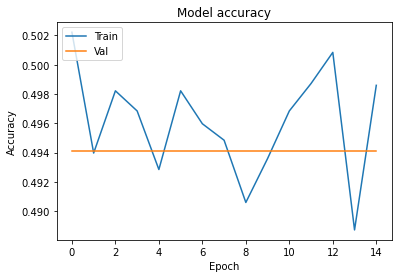

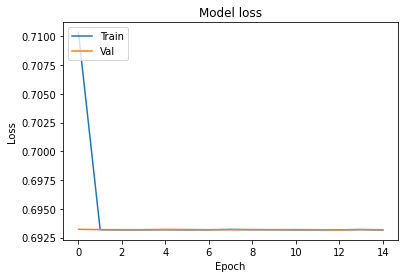

In [16]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_history(history)

In [17]:
def zero_one_loss(dataset, dataset_size):
    
    _, accuracy = model.evaluate(dataset)
    zero_one_loss = dataset_size*(1-accuracy)

    return int(round(zero_one_loss, ndigits=0))

In [18]:
print(f"Zero-one loss on the test set: {zero_one_loss(test, test_size)}")

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 7/79 [=>............................] - ETA: 20s - loss: 0.6932 - accuracy: 0.4978

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


79/79 [==============================] - 23s 244ms/step - loss: 0.6931 - accuracy: 0.5021
Zero-one loss on the test set: 2489


In [19]:
# Clear any previous state
del model
tf.keras.backend.clear_session()

# K-fold cross validation

In [20]:
from sklearn.model_selection import KFold


k_fold = KFold(n_splits=5)
k_splits = k_fold.split(data_paths)
results = []
zero_one_losses = []

for train_index, test_index in k_splits:

    # Get the paths to the data
    train_paths = np.asarray(data_paths)[train_index]
    test_paths = np.asarray(data_paths)[test_index]

    # Make it tf.data.Dataset
    train = tf.data.Dataset.from_tensor_slices(train_paths)
    test = tf.data.Dataset.from_tensor_slices(test_paths)
    
    # Shuffle the dataset
    train = train.shuffle(len(train))
    test = test.shuffle(len(test))

    # Get labels
    train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Configure for performance
    train = configure_for_performance(train)
    test = configure_for_performance(test)

    # Create the model
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(8, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
    
    model.fit(
        train,
        epochs=n_epochs,
        verbose=0
    )
    
    zero_one_losses.append(zero_one_loss(test, len(test_index)))
    
    # Clear any previous state
    del model
    tf.keras.backend.clear_session()

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 

22/79 [=======>......................] - ETA: 7s - loss: 0.9806 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


62/79 [======================>.......] - ETA: 2s - loss: 0.9806 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


79/79 [==============================] - 11s 110ms/step - loss: 0.9806 - accuracy: 0.0000e+00


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9

42/79 [==============>...............] - ETA: 5s - loss: 1.8192 - accuracy: 0.6432

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


61/79 [======================>.......] - ETA: 2s - loss: 1.8711 - accuracy: 0.6358

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


79/79 [==============================] - 11s 115ms/step - loss: 1.8581 - accuracy: 0.6354


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker

 8/79 [==>...........................] - ETA: 10s - loss: 0.6931 - accuracy: 0.5059

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


49/79 [=================>............] - ETA: 4s - loss: 0.6932 - accuracy: 0.4939

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


79/79 [==============================] - 12s 129ms/step - loss: 0.6932 - accuracy: 0.4997


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker

19/79 [======>.......................] - ETA: 8s - loss: 0.9765 - accuracy: 0.0000e+00

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


28/79 [=========>....................] - ETA: 7s - loss: 0.9765 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


79/79 [==============================] - 11s 114ms/step - loss: 0.9765 - accuracy: 0.0000e+00


Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd

52/79 [==================>...........] - ETA: 3s - loss: 0.9766 - accuracy: 0.0000e+00

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


79/79 [==============================] - 10s 108ms/step - loss: 0.9766 - accuracy: 0.0000e+00


In [21]:
mean_loss = np.round(np.mean(zero_one_losses), decimals=0)
std_loss = np.round(np.std(zero_one_losses), decimals=0)
print(f'The mean of zero-one loss is {int(mean_loss)}, with a standard deviation of {int(std_loss)} missmatched samples')

The mean of zero-one loss is 3864, with a standard deviation of 1406 missmatched samples
